# Lese inn og forstå dataene

Vi bruker Pandas til å lese inn dataene, og lager oss en `DataFrame` med kun de kolonnene vi er interessert i å se på. Her gjør vi også noen forenklinger:

 - Kolonnen `white` indikerer om personen er "hvit" eller ikke, hvor vi definerer hvit som gruppen ("race") "Caucasian" i det originale datasettet
 - Kolonnen `predicted` indikerer om personen er predikert til å begå nye lovbrudd
 - Kolonnen `actual` indikerer om personen faktisk begikk nye lovbrudd

In [1]:
import pandas as pd

data = pd.read_csv("../data/compas-scores-two-years.csv")
df = pd.DataFrame({ 
    "sex": data.sex,
    "white": data.race == "Caucasian",
    "score": data.decile_score,
    "predicted": data.score_text != "Low",
    "actual": data.is_recid == 1
})
df

,sex,white,score,predicted,actual
0,Male,False,1,False,False
1,Male,False,3,False,True
2,Male,False,4,False,True
3,Male,False,8,True,False
4,Male,False,1,False,False
...,...,...,...,...,...
7209,Male,False,7,True,False
7210,Male,False,3,False,False
7211,Male,False,1,False,False
7212,Female,False,2,False,False


## Predikerte og faktisk gjentatte forbrytelser

Vi lager firefeltstabeller for å se på hvor ofte ulike grupperinger (kvinner/menn og hvite/svarte) blir prediktert å gjenta forbrytelser og faktisk gjør det.

In [2]:
def get_relative_frequency(group, target):
    group_size = len(df[group])
    target_size = len(df[group & target])
    rel_freq = target_size/group_size
    return f'{rel_freq*100:.1f}%'

def four_field_table(group, group_name, rest_name):
    return pd.DataFrame({
        "Predikert": [get_relative_frequency(group, df.predicted), get_relative_frequency(~group, df.predicted)],
        "Faktisk": [get_relative_frequency(group, df.actual), get_relative_frequency(~group, df.actual)],
    }, index = [group_name, rest_name])

### Prediktert og faktisk gjentatte forbrytelser etter hudfarge

In [3]:
four_field_table(df.white, "Hvite", "Ikke-hvite")

,Predikert,Faktisk
Hvite,34.8%,41.8%
Ikke-hvite,51.7%,51.4%


### Predikert og faktisk gjentatte forbrytelser etter kjønn

In [4]:
four_field_table(df.sex == 'Male', "Menn", "Kvinner")

,Predikert,Faktisk
Menn,46.8%,50.5%
Kvinner,42.4%,38.0%


## Fare-score

COMPAS gir en score fra 1 til 10 for hver at gjerningspersonen i en sak er "farlig". Vi ser på fordelingen av denne scoren i forskjellige grupper.

In [5]:
def plot_score_dist(df, title, group, group_name, rest_name):
    pd.DataFrame({
        "Alle": df.score.value_counts(normalize = True),
        group_name: df[group].score.value_counts(normalize = True),
        rest_name: df[~group].score.value_counts(normalize = True)
    }).sort_index().plot(title = title, style = {"Alle": "k--"})

### Fordeling av score etter hudfarge

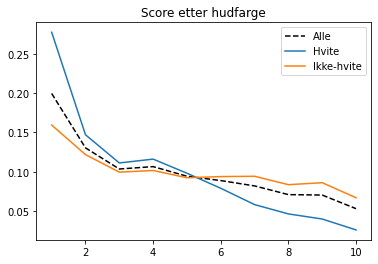

In [6]:
plot_score_dist(df, "Score etter hudfarge", df.white, "Hvite", "Ikke-hvite")

### Fordeling av score etter kjønn

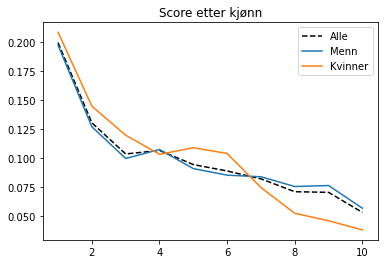

In [7]:
plot_score_dist(df, "Score etter kjønn", df.sex == 'Male', "Menn", "Kvinner")

### Fordeling av score etter gjentatt forbrytelse

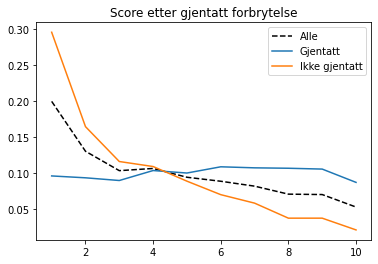

In [8]:
plot_score_dist(df, "Score etter gjentatt forbrytelse", df.actual, "Gjentatt", "Ikke gjentatt")

### Fordeling av score etter gjentatte forbrytelser, hvite

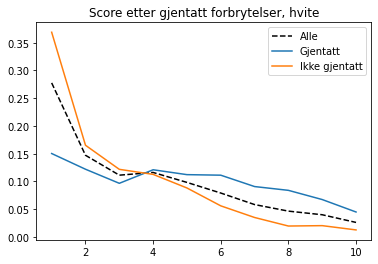

In [9]:
df_white = df[df.white]
plot_score_dist(df_white, "Score etter gjentatt forbrytelser, hvite", df_white.actual, "Gjentatt", "Ikke gjentatt")

### Fordeling av score etter gjentatte forbrytelser, ikke-hvite

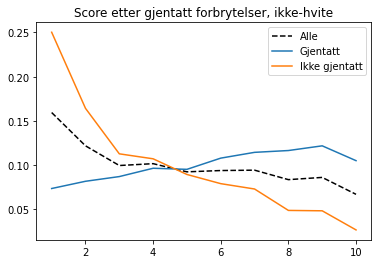

In [10]:
df_non_white = df[~df.white]
plot_score_dist(df_non_white, "Score etter gjentatt forbrytelser, ikke-hvite", df_non_white.actual, "Gjentatt", "Ikke gjentatt")

# Betinget sannsynlighet
Positiv prediktiv verdi er sannsynligheten for at en person som ble predikert å begå nye lovbrudd faktisk begikk nye lovbrudd. Sensitivitet er det "motsatte": sannsynligheten for at en person som faktisk begikk nye lovbrudd ble predikert å gjøre det.

De to sannsynligheten er relatert med Bayes setning.  

In [11]:
def conditional_prob(df):
    a = pd.DataFrame({
        "Ikke gjentatt": df[~df.actual].predicted.value_counts().sort_index(),
        "Gjentatt lovbrudd": df[df.actual].predicted.value_counts().sort_index()
    }).rename({False: "Ikke predikert", True: "Predikert"}) / len(df)
    display(a)
    pos_pred = a["Gjentatt lovbrudd"]["Predikert"] / a.loc["Predikert"].sum()
    print("Pos. pred. verdi: ", pos_pred)
    sens = a["Gjentatt lovbrudd"]["Predikert"] / a["Gjentatt lovbrudd"].sum()
    print("Sensitivitet: ", sens)
    
print("Alle")
conditional_prob(df)

print("\nHvite")
conditional_prob(df[df.white])

print("\nIkke-hvite")
conditional_prob(df[~df.white])

print("\nMenn")
conditional_prob(df[df.sex == 'Male'])

print("\nKvinner")
conditional_prob(df[df.sex == 'Female'])

Alle


,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,0.355697,0.184502
Predikert,0.163155,0.296645


Pos. pred. verdi:  0.6451612903225806
Sensitivitet:  0.6165370210314031

Hvite


,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,0.447433,0.204564
Predikert,0.134882,0.213121


Pos. pred. verdi:  0.6124121779859485
Sensitivitet:  0.5102439024390244

Ikke-hvite


,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,0.308403,0.174160
Predikert,0.177731,0.339706


Pos. pred. verdi:  0.656516443361754
Sensitivitet:  0.6610793131643501

Menn


,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,0.339062,0.192473
Predikert,0.155525,0.312940


Pos. pred. verdi:  0.6680117388114453
Sensitivitet:  0.6191771506290378

Kvinner


,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,0.425090,0.151254
Predikert,0.194982,0.228674


Pos. pred. verdi:  0.5397631133671742
Sensitivitet:  0.6018867924528302


# Predikere prediksjonen

In [12]:
from sklearn.linear_model import LogisticRegression
import numpy as np

categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)

Y = data["score_text"] != "Low"

model = LogisticRegression(max_iter=1000)
model.fit(X, Y)

print(model.coef_)
print(model.intercept_)

[[ 0.25987589  0.63271886 -1.26300553  1.26432389  0.50714728 -0.2013607
  -0.30955637  0.62890969 -0.81408274  0.22142297 -0.26303721]]
[-1.47159474]


In [13]:
black_coef = model.coef_[0, list(X.columns).index('race_African-American')]
intercept = model.intercept_[0]

control = 1/(1+np.exp(-intercept))
racialBias = np.exp(black_coef) / (1 + control * (np.exp(black_coef) - 1))
racialBias

1.4782437952042453